<a href="https://colab.research.google.com/github/katemartian/Photometry_data_processing/blob/master/make_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Create plots for Jove

# Give access to your google drive, so you can extract data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Execute functions for FP data analysis

In [0]:
%cd /content/drive/My Drive/!lab/
%run FPanalysis.ipynb

/content/drive/My Drive/!lab
All FP functions are ready to use


In [0]:
# Plot style
mpl.style.use('classic')

# Set your working directory and get file names


In [0]:
%cd /content/drive/My Drive/!lab/Manuscripts/Jove/figures/make plots/
folder = os.getcwd()
files = find_file(folder,'.xlsx')

/content/drive/My Drive/!lab/Manuscripts/Jove/figures/make plots


In [0]:
files

['LHA12_LHb_airpuff1.xlsx',
 'VR5_airpuff.xlsx',
 'forKate.xlsx',
 'LHA6_1_DRN_LHb_airpuff4.xlsx',
 'LHA2_1_DRN_LHb_airpuff4.xlsx',
 'GFP2_LHbr_airpuffs.xlsx',
 'GFP1_LHbr_airpuffs.xlsx']

# Function to read  your data and info about your experiments

In [0]:
def get_data(name,folder):
    
# Extract experiment info    
  sepname = name.split('_')  
# LHA mice (injected in LHA, implanted above LHb, VTA, DRN)
  if name[:3] == 'LHA':
      output = ['green1','LHA-DRN','LHA-LHb']
      green = ['green1','LHA-DRN','LHA-LHb']
      red = ['red1','red2','red3']
      fiber = 2 # there was just one fiber
# LHA mice (injected in LHA, implanted above LHb, VTA, DRN)
  if name[:5] == 'LHA12':
      output = ['LHA-LHb']
      green = ['LHA-LHb']
      red = ['red1']
      fiber = 0 # there was just one fiber
# VR mice (injected in VTA, implanted above NAc, VTA, RMTg)
  elif name[:2] == 'VR':
      output = ['VTA-NAc','VTA','VTA-RMTg']
      green = ['VTA-NAc','VTA','VTA-RMTg']
      red = ['red1','red2','red3']
      fiber = 1 # choose the fiber connected to VTA
# GFP mice 
  elif name[:3] == 'GFP':
      output = ['LHb']
      green = ['LHb']
      red = ['red1']
      fiber = 0 # there was just one fiber    

# Experiment info        
  exp_info = {'mouse': sepname[0],
              'output': output,
              'green': green,
              'red': red,
              'test': sepname[-1][:-5],
              'fiber':fiber,
              'folder': folder}  
  
# Read data
  df_fp = pd.read_excel(os.path.join(folder,name),index_col=False)
  
  return exp_info,df_fp

# Function to get your behavior data (such as airpuffs, ...)

In [0]:
def get_behavior(df_fp):

  # FP events
    airpuff = np.array(df_fp['Event_410nm'])
  # Find diff
    diff_airpuff = np.diff(airpuff)
  # Diff > 0 -> Airpuff
    events = [i for i in range(len(diff_airpuff)) if diff_airpuff[i-1]>0]
  # Convert to numpy and reshape
    events = np.array(events).reshape(len(events),1)
  
    return events

# Make figures that show each step of FP data analysis

## Choose file and extract data 

In [0]:
name = 'LHA12_LHb_airpuff1.xlsx'
Hz = 10 # Frequancy of 470 signal

# Extract experiment info, tables with green and red signal, and anymaze data
exp_info,df_fp = get_data(name,folder)

# Extract behavior data:
rawevents = get_behavior(df_fp)

In [0]:
fiber = exp_info['fiber']

# Read signal
raw415 = df_fp['MeanInt_410nm_'+str(fiber*2+1)][2:2400]
try:
    raw470 = df_fp['MeanInt_470nm_'+str(fiber*2+1)][2:2400]
except:
    raw470 = df_fp['MeanInt_470560nm_'+str(fiber*2+1)][2:2400]              

rawtime = np.arange(0,len(raw415)/(1*Hz),1/Hz)

rawevents = rawevents[rawevents < 2400]

In [0]:
raw415 = raw415 * 2**16 / 2**8
raw470 = raw470 * 2**16 / 2**8

## Plot row data

In [0]:
# Find Slope using airPLS algorithm
order = 0.5
itermax = 50
lambd = 5e4
base415=airPLS(raw415.T,lambda_=lambd,porder=order,itermax=itermax).reshape(len(raw415),1)
base470=airPLS(raw470.T,lambda_=lambd,porder=order,itermax=itermax).reshape(len(raw470),1)

In [0]:
# Smooth signals
smooth_win=int(1*Hz) # 1 sec window smooth
raw415 = np.array(raw415.rolling(window=smooth_win).mean()).reshape(len(raw415),1)
raw470 = np.array(raw470.rolling(window=smooth_win).mean()).reshape(len(raw470),1)
rawtime = rawtime.reshape(len(rawtime),1)

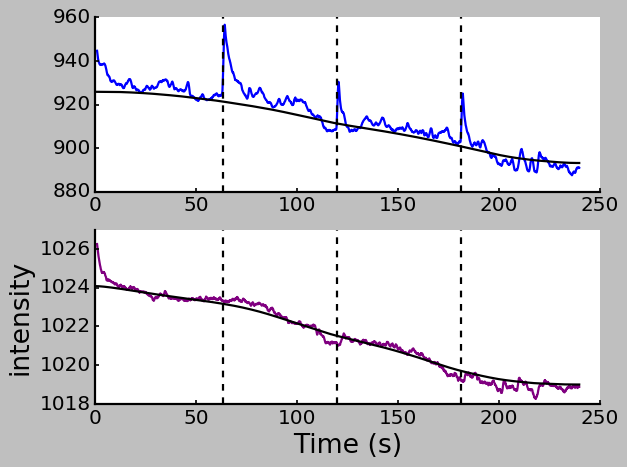

In [0]:
plt.close('all')

fig1 = plt.figure(figsize=(8, 6))

# Plot Calcium signal, Slope, Airpuffs 
ax1 = fig1.add_subplot(211)
ax1.plot(rawtime,raw470,'blue',linewidth=2)
ax1.plot(rawtime,base470,'black',linewidth=2)
for event in rawevents:
    ax1.axvline(x=rawtime[event],color='black',linestyle='--',linewidth=2)

# Plot Isosbestic signal, Slope, Airpuffs
ax2 = fig1.add_subplot(212)
ax2.plot(rawtime,raw415,'purple',linewidth=2)
ax2.plot(rawtime,base415,'black',linewidth=2)
for event in rawevents:
    ax2.axvline(x=rawtime[event],color='black',linestyle='--',linewidth=2)
    
# Set axis names
ax1.set_ylabel('',fontsize=24,multialignment='center')
ax2.set_ylabel('intensity',fontsize=24,multialignment='center')
ax2.set_xlabel('Time (s)', fontsize=24, multialignment='center')

# Some style magic
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='x', **tkw)
ax1.tick_params(axis='y', **tkw)
ax2.tick_params(axis='x', **tkw)
ax2.tick_params(axis='y', **tkw)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)

ax1.yaxis.set_ticks([880,900,920,940,960])
ax2.yaxis.set_ticks([1018,1020,1022,1024,1026])

plt.ticklabel_format(useOffset=False)
plt.tight_layout()

# Show current plot
plt.show()


In [0]:
# Save current plot if you like it
fig1.savefig('1raw.pdf')

## Plot flatten data

In [0]:
remove = 5*Hz # remove first 5 sec

In [0]:
# Remove 
## begining of the signal 
## baseline
Int415 = (raw415[remove:] - base415[remove:])
Int470 = (raw470[remove:] - base470[remove:])
time = rawtime[remove:]
events = rawevents - remove

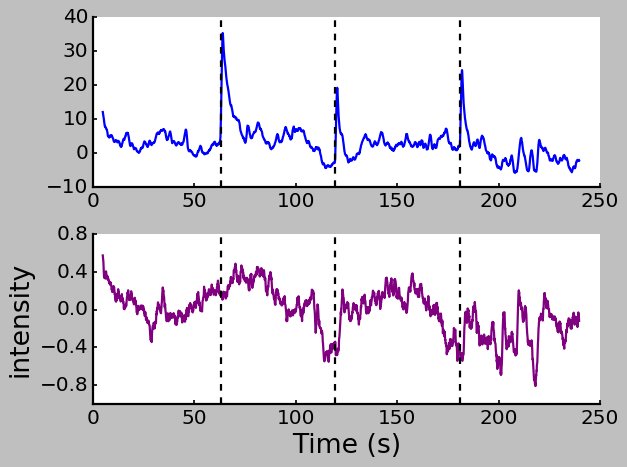

In [0]:
plt.close('all')

fig2 = plt.figure(figsize=(8, 6))

# Plot Calcium signal and Airpuffs
ax1 = fig2.add_subplot(211)
ax1.plot(time,Int470,'blue',linewidth=2)
for i in events:
    ax1.axvline(x=time[i],color='black',linestyle='--',linewidth=2)
    
# Plot Isosbestic signal and Airpuffs
ax2 = fig2.add_subplot(212)
ax2.plot(time,Int415,'purple',linewidth=2)
for i in events:
    ax2.axvline(x=time[i],color='black',linestyle='--',linewidth=2)  

# Set axis names
ax1.set_ylabel('',fontsize=24,multialignment='center')
ax2.set_ylabel('intensity',fontsize=24,multialignment='center')
ax2.set_xlabel('Time (s)', fontsize=24, multialignment='center')

# Some style magic
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='x', **tkw)
ax1.tick_params(axis='y', **tkw)
ax2.tick_params(axis='x', **tkw)
ax2.tick_params(axis='y', **tkw)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)

#ax1.yaxis.set_ticks([880,900,920,940,960])
ax2.yaxis.set_ticks([-0.8,-0.4,0,0.4,0.8])

plt.ticklabel_format(useOffset=False)
plt.tight_layout()

# Show currnet plot
plt.show()

In [0]:
# Save currnet plot if you like it
fig2.savefig('2flatten.pdf')

## Plot standardized data

In [0]:
# Standardize signals by subtracting mean and deviding by standart deviation
Int470 = (Int470 - Int470.mean()) / Int470.std()
Int415 = (Int415 - Int415.mean()) / Int415.std()

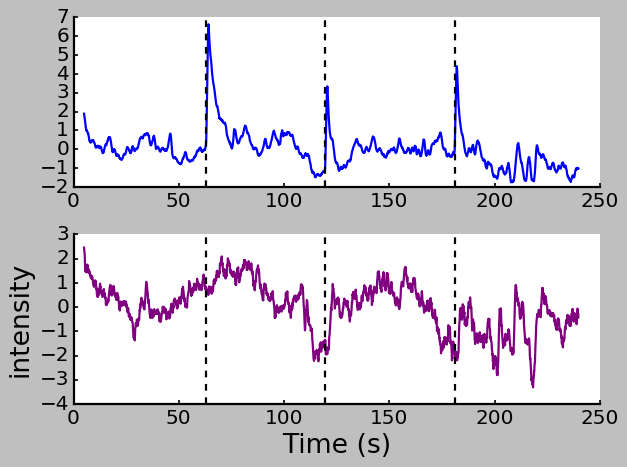

In [0]:
plt.close('all')

fig3 = plt.figure(figsize=(8, 6))

# Plot Calcium signal and Airpuffs
ax1 = fig3.add_subplot(211)
ax1.plot(time,Int470,'blue',linewidth=2)
for i in events:
    ax1.axvline(x=time[i],color='black',linestyle='--',linewidth=2)
    
# Plot Isosbestic signal and Airpuffs   
ax2 = fig3.add_subplot(212)
ax2.plot(time,Int415,'purple',linewidth=2)
for i in events:
    ax2.axvline(x=time[i],color='black',linestyle='--',linewidth=2)

# Set axis names
ax1.set_ylabel('',fontsize=24,multialignment='center')
ax2.set_ylabel('intensity',fontsize=24,multialignment='center')
ax2.set_xlabel('Time (s)', fontsize=24, multialignment='center')

# Some style magic
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='x', **tkw)
ax1.tick_params(axis='y', **tkw)
ax2.tick_params(axis='x', **tkw)
ax2.tick_params(axis='y', **tkw)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)

plt.ticklabel_format(useOffset=False)
plt.tight_layout()

# Show current plot 
plt.show()

In [0]:
# Save current plot if you like it
fig3.savefig('3standardized.pdf')

## Plot fit

In [0]:
# Create non-negative robust linear regression fit
def fun(x, a, b):
    return a * x + b
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
            positive=True, random_state=9999, selection='random')
# Fit 
lin.fit(Int415, Int470)
# Create new fitted Isosbestic signal
Int415fit = lin.predict(Int415)
# Change format of the new vecor
Int415fit = Int415fit.reshape(len(Int415fit),1)

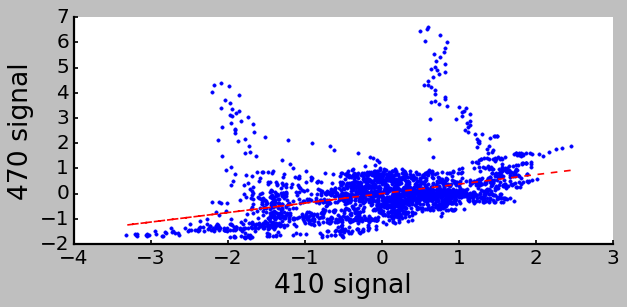

In [0]:
plt.close('all')

fig4 = plt.figure(figsize=(8, 4))

ax1 = fig4.add_subplot(111)
# Plot values of Calcium and Isosbestic signals on one plot
ax1.plot(Int415,Int470,'b.')
# Plot the linear regression
ax1.plot(Int415,Int415fit, 'r--',linewidth=1.5)

# Set axis names
ax1.set_xlabel('410 signal', fontsize=24, multialignment='center')
ax1.set_ylabel('470 signal', fontsize=24, multialignment='center')

# Some style magic
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='x', **tkw)
ax1.tick_params(axis='y', **tkw)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)

plt.ticklabel_format(useOffset=False)
plt.tight_layout()

# Show current plot
plt.show()

In [0]:
# Save current plot if you like it
fig4.savefig('4fit.pdf')

## Plot aligned signals

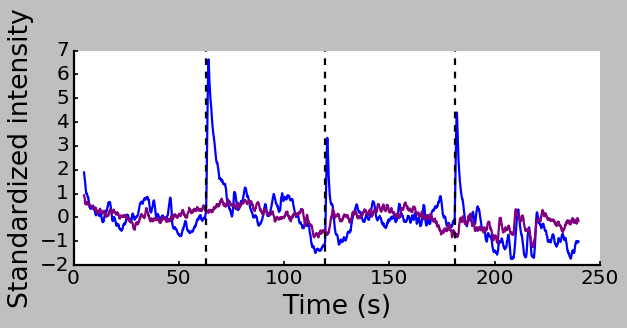

In [0]:
plt.close('all')

fig5 = plt.figure(figsize=(8, 4))

# Plot Calcium and fitted Isosbestic signals, and Airpuffs
ax1 = fig5.add_subplot(111)
ax1.plot(time, Int470, 'blue' ,linewidth=2)
ax1.plot(time, Int415fit, 'purple',linewidth=2)
for i in events:
  ax1.axvline(x=time[i],color='black',linestyle='--',linewidth=2)

# Set axis names
ax1.set_xlabel('Time (s)', fontsize=24, multialignment='center')
ax1.set_ylabel('Standardized intensity', fontsize=24, multialignment='center')

# Some style magic
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='x', **tkw)
ax1.tick_params(axis='y', **tkw)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)

plt.ticklabel_format(useOffset=False)
plt.tight_layout()

# Show current plot
plt.show()


In [0]:
# Save current plot if you like it
fig5.savefig('5aligned.pdf')

## Plot dF/F

In [0]:
# Calculate dF/F
dFF = Int470 - Int415fit

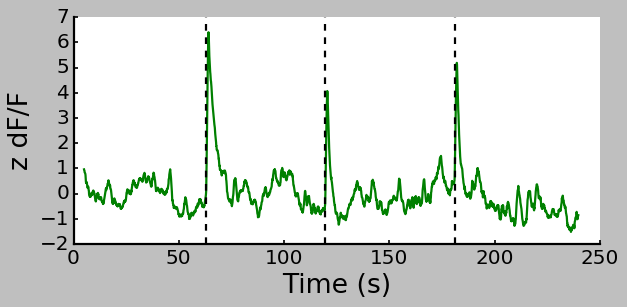

In [0]:
plt.close('all')

fig6 = plt.figure(figsize=(8, 4))

# Plot dF/F and Airpuffs
ax1 = fig6.add_subplot(111)
ax1.plot(time, dFF, 'green' ,linewidth=2)
for i in events:
  ax1.axvline(x=time[i],color='black',linestyle='--',linewidth=2)

# Set axis names
ax1.set_xlabel('Time (s)', fontsize=24, multialignment='center')
ax1.set_ylabel('z dF/F', fontsize=24, multialignment='center')

# Some style magic
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='x', **tkw)
ax1.tick_params(axis='y', **tkw)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)

plt.ticklabel_format(useOffset=False)
plt.tight_layout()

# Show current plot
plt.show()

In [0]:
# Save current plot if you like it
fig6.savefig('6dFF.pdf')

# Show example of leak removal

## Choose file and extract data 

In [0]:
files

['LHA12_LHb_airpuff1.xlsx', 'VR5_airpuff.xlsx', 'forKate.xlsx']

In [0]:
name = 'VR5_airpuff.xlsx'
Hz = 10 # Frequancy of 470 signal

# Extract experiment info, tables with green and red signal, and anymaze data
exp_info,df_fp = get_data(name,folder)

# Extract behavior data:
rawevents = get_behavior(df_fp)

In [0]:
fiber = exp_info['fiber']

# Read signal
raw415 = df_fp['MeanInt_410nm_'+str(fiber*2+1)][2:2400]
try:
    raw470 = df_fp['MeanInt_470nm_'+str(fiber*2+1)][2:2400]
except:
    raw470 = df_fp['MeanInt_470560nm_'+str(fiber*2+1)][2:2400]
try:
    raw560 = df_fp['MeanInt_470nm_'+str(fiber*2+2)][2:2400]
except:
    raw560 = df_fp['MeanInt_470560nm_'+str(fiber*2+2)][2:2400] 

rawtime = np.arange(0,len(raw415)/(1*Hz),1/Hz)

rawevents = rawevents[rawevents < 2400]
rawevents = rawevents[rawevents > 200]

In [0]:
raw560 = raw560 * 2**16 / 2**8
raw470 = raw470 * 2**16 / 2**8

## Plot row data

In [0]:
# Smooth signals
smooth_win=int(1*Hz) # 1 sec window smooth
Int415 = np.array(raw415.rolling(window=smooth_win).mean()).reshape(len(raw415),1)
Int470 = np.array(raw470.rolling(window=smooth_win).mean()).reshape(len(raw470),1)
Int560 = np.array(raw560.rolling(window=smooth_win).mean()).reshape(len(raw560),1)
rawtime = rawtime.reshape(len(rawtime),1)
Int415 = Int415[10:]
Int470 = Int470[10:]
Int560 = Int560[10:]
rawtime = rawtime[10:]

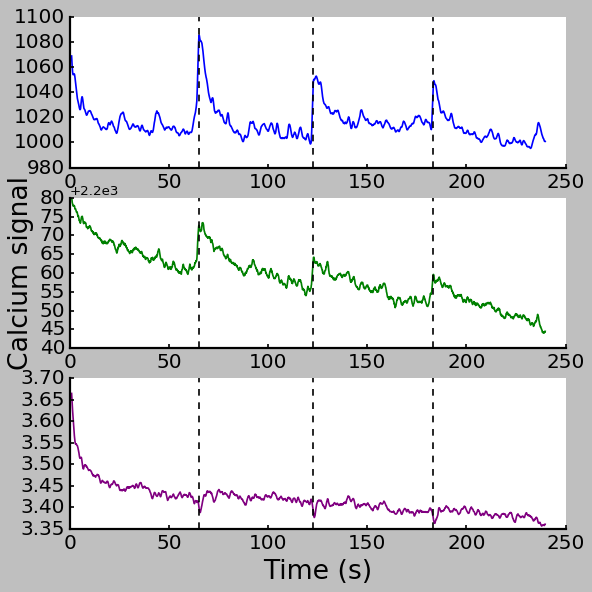

In [0]:
plt.close('all')

fig = plt.figure(figsize=(8, 8))

# Plot Calcium signal, Slope, Airpuffs 
ax1 = fig.add_subplot(311)
ax1.plot(rawtime,Int470,'blue',linewidth=1.5)
for event in rawevents:
    ax1.axvline(x=rawtime[event],color='black',linestyle='--',linewidth=1.5)

# Plot Isosbestic signal, Slope, Airpuffs
ax2 = fig.add_subplot(312)
ax2.plot(rawtime,Int560,'green',linewidth=1.5)
for event in rawevents:
    ax2.axvline(x=rawtime[event],color='black',linestyle='--',linewidth=1.5)
    
# Plot Isosbestic signal, Slope, Airpuffs
ax3 = fig.add_subplot(313)
ax3.plot(rawtime,Int415,'purple',linewidth=1.5)
for event in rawevents:
    ax3.axvline(x=rawtime[event],color='black',linestyle='--',linewidth=1.5)
    
# Set axis names
ax2.set_ylabel('Calcium signal',fontsize=24,multialignment='center')
ax3.set_xlabel('Time (s)', fontsize=24, multialignment='center')

# Some style magic
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.spines['left'].set_linewidth(2)
ax3.spines['bottom'].set_linewidth(2)

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='x', **tkw)
ax1.tick_params(axis='y', **tkw)
ax2.tick_params(axis='x', **tkw)
ax2.tick_params(axis='y', **tkw)
ax3.tick_params(axis='x', **tkw)
ax3.tick_params(axis='y', **tkw)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)

plt.ticklabel_format(useOffset=False)

# Show current plot
plt.show()

## Correct the red signal

In [0]:
# Find Slope using airPLS algorithm
order = 0.5
itermax = 50
lambd = 3e4
base470=airPLS(Int470[:,0].T,lambda_=lambd,porder=order,itermax=itermax).reshape(len(Int470),1)

In [0]:
flatten470 = Int470 - base470
flatten470 = np.nan_to_num(flatten470)

In [0]:
T = 0.05
f = 0.15

leak = flatten470.copy()
leak[leak < T] = 0
leak[:100] = 0 
leak = f*leak
Int560corr = Int560 - leak

In [0]:
# Find Slope using airPLS algorithm
base415=airPLS(Int415[:,0].T,lambda_=lambd,porder=order,itermax=itermax).reshape(len(Int415),1)
base560=airPLS(Int560corr[:,0].T,lambda_=lambd,porder=order,itermax=itermax).reshape(len(Int560corr),1)

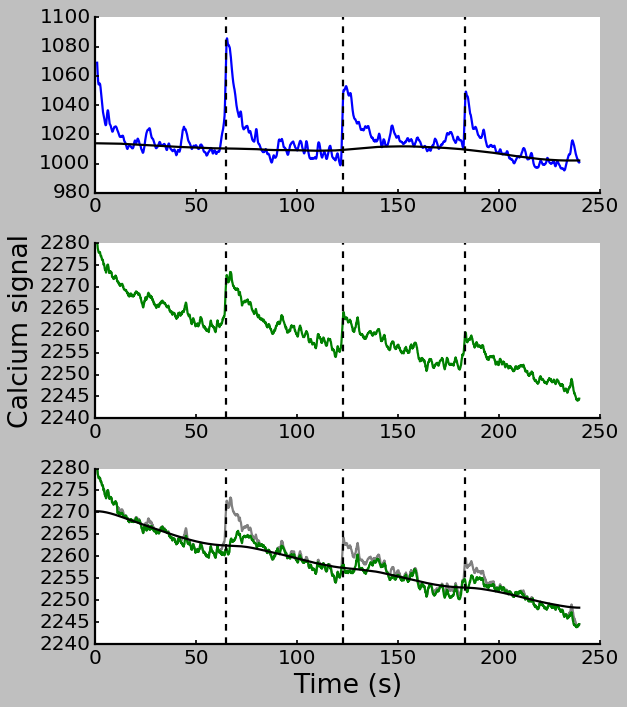

In [0]:
plt.close('all')

fig = plt.figure(figsize=(8, 9))

# Plot Calcium signal and Airpuffs
ax1 = fig.add_subplot(311)
ax1.plot(rawtime,Int470,'blue',linewidth=2)
ax1.plot(rawtime,base470,'black',linewidth=2)
for i in rawevents:
    ax1.axvline(x=rawtime[i],color='black',linestyle='--',linewidth=2)
    
# Plot Isosbestic signal and Airpuffs
ax2 = fig.add_subplot(312)
ax2.plot(rawtime,Int560,'green',linewidth=2)
for i in rawevents:
    ax2.axvline(x=rawtime[i],color='black',linestyle='--',linewidth=2) 
    
plt.ticklabel_format(useOffset=False)
    
# Plot Isosbestic signal and Airpuffs
ax3 = fig.add_subplot(313)
ax3.plot(rawtime,Int560,'gray',linewidth=2)
ax3.plot(rawtime,Int560corr,'green',linewidth=2)
ax3.plot(rawtime,base560,'black',linewidth=2)
for i in rawevents:
    ax3.axvline(x=rawtime[i],color='black',linestyle='--',linewidth=2) 

# Set axis names
#ax1.set_ylabel('Calcium signal',fontsize=24,multialignment='center')
ax2.set_ylabel('Calcium signal',fontsize=24,multialignment='center')
#ax3.set_ylabel('Calcium signal',fontsize=24,multialignment='center')
ax3.set_xlabel('Time (s)', fontsize=24, multialignment='center')

# Some style magic
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.spines['left'].set_linewidth(2)
ax3.spines['bottom'].set_linewidth(2)

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='x', **tkw)
ax1.tick_params(axis='y', **tkw)
ax2.tick_params(axis='x', **tkw)
ax2.tick_params(axis='y', **tkw)
ax3.tick_params(axis='x', **tkw)
ax3.tick_params(axis='y', **tkw)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)

#ax1.yaxis.set_ticks([3.9,4.0,4.1,4.2])
#ax2.yaxis.set_ticks([8.78,8.82,8.86,8.90])
#ax3.yaxis.set_ticks([8.78,8.82,8.86,8.90])

plt.ticklabel_format(useOffset=False)
plt.tight_layout()

# Show currnet plot
plt.show()

In [0]:
# Save
fig.savefig('leak.pdf')

## Remove beginning and decay

In [0]:
# Remove 
## begining of the signal
remove = 100 # remove first sec
## baseline
Int415 = (Int415[remove:] - base415[remove:])
Int470 = (Int470[remove:] - base470[remove:])
Int560corr = (Int560corr[remove:] - base560[remove:])
time = rawtime[remove:]
events = rawevents - remove
events = events[events > 0]

## Standardized data

In [0]:
# Standardize signals by subtracting mean and deviding by standart deviation
Int470 = (Int470 - Int470.mean()) / Int470.std()
Int415 = (Int415 - Int415.mean()) / Int415.std()
Int560corr = (Int560corr - Int560corr.mean()) / Int560corr.std()

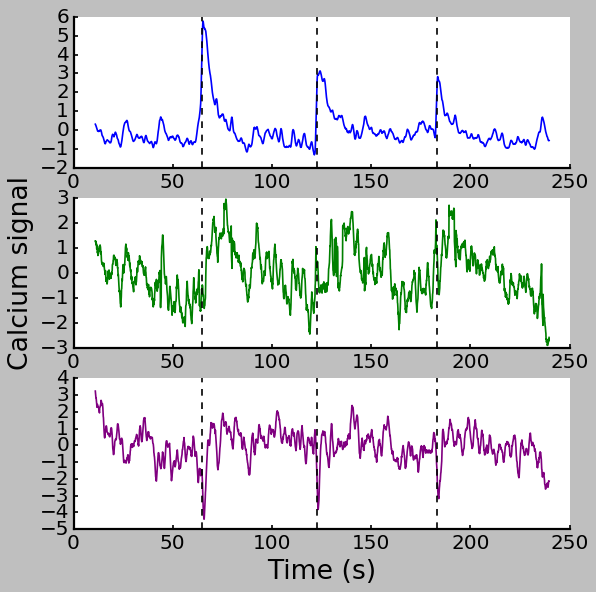

In [0]:
plt.close('all')

fig = plt.figure(figsize=(8, 8))

# Plot Calcium signal, Slope, Airpuffs 
ax1 = fig.add_subplot(311)
ax1.plot(time,Int470,'blue',linewidth=1.5)
for event in events:
    ax1.axvline(x=time[event],color='black',linestyle='--',linewidth=1.5)

# Plot Isosbestic signal, Slope, Airpuffs
ax2 = fig.add_subplot(312)
ax2.plot(time,Int560corr,'green',linewidth=1.5)
for event in events:
    ax2.axvline(x=time[event],color='black',linestyle='--',linewidth=1.5)
    
# Plot Isosbestic signal, Slope, Airpuffs
ax3 = fig.add_subplot(313)
ax3.plot(time,Int415,'purple',linewidth=1.5)
for event in events:
    ax3.axvline(x=time[event],color='black',linestyle='--',linewidth=1.5)
    
# Set axis names
ax2.set_ylabel('Calcium signal',fontsize=24,multialignment='center')
ax3.set_xlabel('Time (s)', fontsize=24, multialignment='center')

# Some style magic
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.spines['left'].set_linewidth(2)
ax3.spines['bottom'].set_linewidth(2)

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='x', **tkw)
ax1.tick_params(axis='y', **tkw)
ax2.tick_params(axis='x', **tkw)
ax2.tick_params(axis='y', **tkw)
ax3.tick_params(axis='x', **tkw)
ax3.tick_params(axis='y', **tkw)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)

plt.ticklabel_format(useOffset=False)

# Show current plot
plt.show()

## Plot fit

In [0]:
# Create non-negative robust linear regression fit
def fun(x, a, b):
    return a * x + b
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
            positive=True, random_state=9999, selection='random')

# Fit isosbestic signal to green data
# Fit 
lin.fit(Int415, Int470)
# Create new fitted Isosbestic signal
Int415fit470 = lin.predict(Int415)
# Change format of the new vecor
Int415fit470 = Int415fit470.reshape(len(Int415fit470),1)

# Fit isosbestic signal to red data
# Fit 
lin.fit(Int415, Int560corr)
# Create new fitted Isosbestic signal
Int415fit560 = lin.predict(Int415)
# Change format of the new vecor
Int415fit560 = Int415fit560.reshape(len(Int415fit560),1)

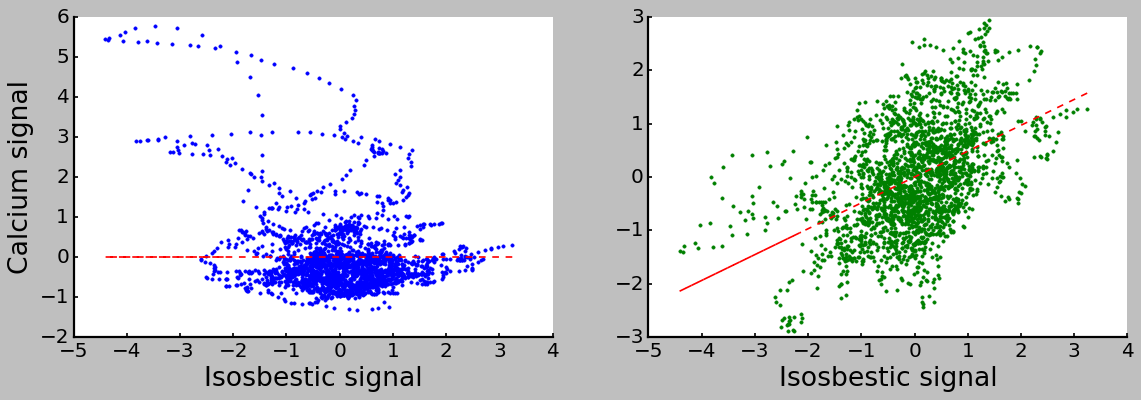

In [0]:
plt.close('all')

fig = plt.figure(figsize=(17, 5))

ax1 = fig.add_subplot(121)
# Plot values of Calcium and Isosbestic signals on one plot
ax1.plot(Int415,Int470,'b.')
# Plot the linear regression
ax1.plot(Int415,Int415fit470, 'r--',linewidth=1.5)

ax2 = fig.add_subplot(122)
# Plot values of Calcium and Isosbestic signals on one plot
ax2.plot(Int415,Int560corr,'g.')
# Plot the linear regression
ax2.plot(Int415,Int415fit560, 'r--',linewidth=1.5)

# Set axis names
ax1.set_xlabel('Isosbestic signal', fontsize=24, multialignment='center')
ax1.set_ylabel('Calcium signal', fontsize=24, multialignment='center')
ax2.set_xlabel('Isosbestic signal', fontsize=24, multialignment='center')

# Some style magic
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='x', **tkw)
ax1.tick_params(axis='y', **tkw)
ax2.tick_params(axis='x', **tkw)
ax2.tick_params(axis='y', **tkw)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)

plt.ticklabel_format(useOffset=False)

# Show current plot
plt.show()

## Plot aligned signals

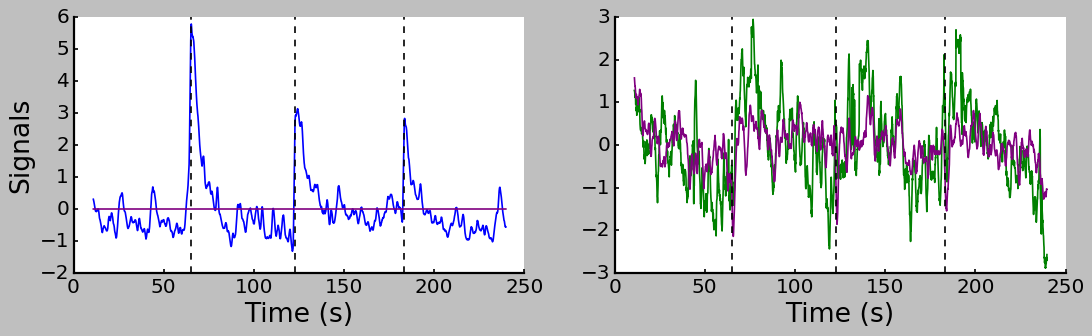

In [0]:
plt.close('all')

fig = plt.figure(figsize=(16, 4))

# Plot Calcium and fitted Isosbestic signals, and Airpuffs
ax1 = fig.add_subplot(121)
ax1.plot(time, Int470, 'blue' ,linewidth=1.5)
ax1.plot(time, Int415fit470, 'purple',linewidth=1.5)
for i in events:
  ax1.axvline(x=time[i],color='black',linestyle='--',linewidth=1.5)
  
# Plot Calcium and fitted Isosbestic signals, and Airpuffs
ax2 = fig.add_subplot(122)
ax2.plot(time, Int560corr, 'green' ,linewidth=1.5)
ax2.plot(time, Int415fit560, 'purple',linewidth=1.5)
for i in events:
  ax2.axvline(x=time[i],color='black',linestyle='--',linewidth=1.5)

# Set axis names
ax1.set_xlabel('Time (s)', fontsize=24, multialignment='center')
ax1.set_ylabel('Signals', fontsize=24, multialignment='center')
ax2.set_xlabel('Time (s)', fontsize=24, multialignment='center')

# Some style magic
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='x', **tkw)
ax1.tick_params(axis='y', **tkw)
ax2.tick_params(axis='x', **tkw)
ax2.tick_params(axis='y', **tkw)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)

plt.ticklabel_format(useOffset=False)

# Show current plot
plt.show()


## Plot dF/F

In [0]:
# Calculate dF/F
dFF_green = Int470 - Int415fit470
dFF_red = Int560corr - Int415fit560

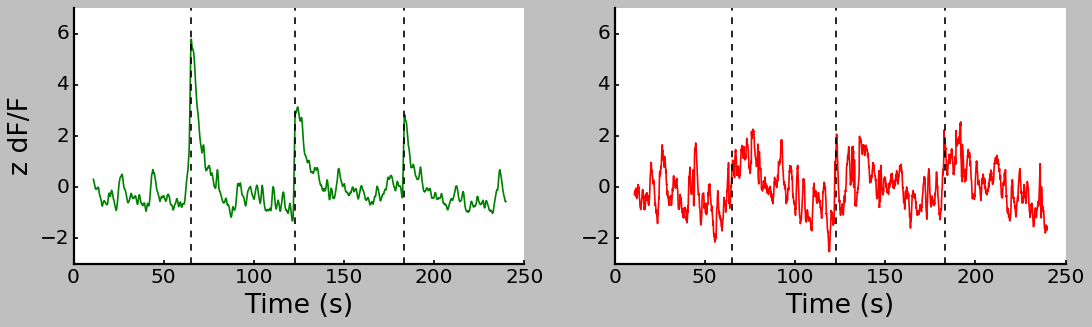

In [0]:
plt.close('all')

fig = plt.figure(figsize=(16, 4))

ymax = max(7,1.1*max(dFF_green),1.1*max(dFF_red))
ymin = min(-3,1.1*min(dFF_green),1.1*min(dFF_red))

# Plot dF/F and Airpuffs
ax1 = fig.add_subplot(121)
ax1.plot(time, dFF_green, 'green',linewidth=1.5)
for i in events:
  ax1.axvline(x=time[i],color='black',linestyle='--',linewidth=1.5)

# Plot dF/F and Airpuffs
ax2 = fig.add_subplot(122)
ax2.plot(time, dFF_red,'red',linewidth=1.5)
for i in events:
  ax2.axvline(x=time[i],color='black',linestyle='--',linewidth=1.5)
  
# Set axis names
ax1.set_xlabel('Time (s)', fontsize=24, multialignment='center')
ax1.set_ylabel('z dF/F', fontsize=24, multialignment='center')
ax2.set_xlabel('Time (s)', fontsize=24, multialignment='center')

# Some style magic
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='x', **tkw)
ax1.tick_params(axis='y', **tkw)
ax2.tick_params(axis='x', **tkw)
ax2.tick_params(axis='y', **tkw)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)

ax1.set_ylim([ymin,ymax])
ax2.set_ylim([ymin,ymax])

plt.ticklabel_format(useOffset=False)

# Show current plot
plt.show()

# GFP example

In [0]:
name = 'GFP1_LHbr_airpuffs.xlsx'
Hz = 5 # Frequancy of 470 signal

# Extract experiment info, tables with green and red signal, and anymaze data
exp_info,df_fp = get_data(name,folder)

# Extract behavior data:
rawevents = get_behavior(df_fp)

In [0]:
fiber = exp_info['fiber']

# Read signal
raw415 = df_fp['MeanInt_410nm_'+str(fiber*2+1)][2:2400]
try:
    raw470 = df_fp['MeanInt_470nm_'+str(fiber*2+1)][2:2400]
except:
    raw470 = df_fp['MeanInt_470560nm_'+str(fiber*2+1)][2:2400]              

rawtime = np.arange(0,len(raw415)/(1*Hz),1/Hz)

rawevents = rawevents[rawevents < 2400]

In [0]:
raw415 = raw415 * 2**16 / 2**8
raw470 = raw470 * 2**16 / 2**8

In [0]:
events

array([[ 204,  511,  804, 1163, 1413]])

In [0]:
# Time based on frequency 
rawtime = np.arange(0,len(df_fp)/(1*Hz),1/Hz)
# Remove beginning of the signals, where alignment is difficult
remove = 20*Hz
time = rawtime[remove:]
events = rawevents - remove
events = events[np.all(events > 0, axis=0)]  

In [0]:
zdFF = get_zdFF(raw415,raw470,time,5e4,remove,events,exp_info)

In [0]:
start = 0
end = 750

zdFF_part = zdFF[start:end]

time_part = np.arange(0,(end-start)/Hz,1/Hz)

events_part = events[events > start]
events_part = events_part[events_part < end]
events_part = events_part - start

In [0]:
events_part

array([204, 511])

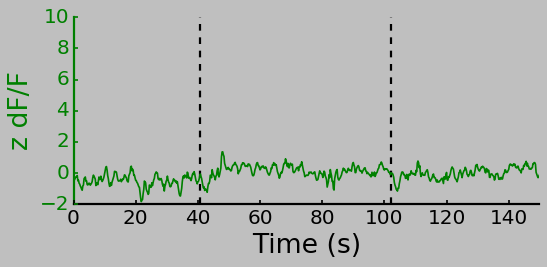

In [0]:
fig = plt.figure(figsize=(7, 3.5))

ax = fig.add_subplot(111)
ax.patch.set_visible(False) # hide the 'canvas'
ax.plot(time_part, zdFF_part, 'green', linewidth=1.5)
ax.vlines(time_part[events_part],-2,10,color='black',linestyle='--',linewidth=2)  
    
ax.set_xlim(min(time_part), max(time_part))
ax.set_ylim(-2, 10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('green')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)


ax.set_xlabel('Time (s)', fontsize=24, multialignment='center')
ax.set_ylabel('z dF/F', color='green', fontsize=24,multialignment='center')

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='x', **tkw)
ax.tick_params(axis='y', colors='green', **tkw)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)

plt.tight_layout()
plt.show()

In [0]:
fig.savefig(folder+'/GFP_AP_example.pdf')

# Summary of LHA-LHb recordings

In [0]:
# Choose the window for Arrays
Hz = 10
sec = 5
win = int(sec*Hz)

# Pr-set arrays
Mice = []
Paths = []
Tests = []
Arrays = []

LHA_files = find_file(folder,'LHA')
# Analyse all files
for name in LHA_files:   

# Extract experiment info, tables with green and red signal, and anymaze data
  exp_info,df_fp = get_data(name,folder)

# Extract behavior data. Airpuffs
  rawevents = get_behavior(df_fp)
  
# Experiment time based on frequency 
  rawtime = np.arange(0,len(df_fp)/(1*Hz),1/Hz)
  
# Remove beginning of the signals, where alignment is difficult
  remove = 20*Hz
  time = rawtime[remove:]
  events = rawevents - remove
  events = events[np.all(events > 0, axis=1)]
    
# Get number of fibers
  fiber = exp_info['fiber']
        
  print(exp_info['mouse'])

# Get signals
  raw415 = df_fp['MeanInt_410nm_'+str(fiber*2+1)]
  try:
      raw470 = df_fp['MeanInt_470nm_'+str(fiber*2+1)]
  except:
      raw470 = df_fp['MeanInt_470560nm_'+str(fiber*2+1)]
        
# Get z dF/F
  zdFF = get_zdFF(raw415,raw470,time,5e4,remove,events,exp_info,
           color='green',fiber=fiber,test='airpuff')
# Get Arrays of signal aligned to airpuffs
  Array_events,_ = norm_events(zdFF,events=events)

# Create vectors for table
  mouse = [exp_info['mouse']] * Array_events.shape[1]
  path = [exp_info['green'][fiber]] * Array_events.shape[1]
  test = [exp_info['test']] * Array_events.shape[1]
  Mice.extend(mouse)
  Paths.extend(path)
  Tests.extend(test)
  Arrays.extend(Array_events.T)

Info = pd.DataFrame({'mouse': Mice, 'path': Paths, 'test': Tests})
Arrays = np.array(Arrays).reshape(len(Mice),win*2).astype('float64')
Arrays = pd.DataFrame(Arrays)
Arrays.columns = [str((i-win)/Hz) for i in range(2*win)]

# Combine the vectors
Arrays = pd.concat([Info, Arrays], axis=1)

LHA12
LHA6
LHA2


In [0]:
LHb_start

In [0]:
LHb_start = Arrays.iloc[:,3:].T # groupby(['mouse']).mean().T
Mean_LHb_start = LHb_start.mean(axis=1)
Error_LHb_start = LHb_start.std(axis=1) / np.sqrt(LHb_start.shape[1])

In [0]:
LHb_baseline = list(LHb_start.iloc[30:40,:].mean())
LHb_airpuff = list(LHb_start.iloc[60:65,:].mean())
LHb_mice = list(LHb_start.columns.values)
LHb_stats = pd.DataFrame({'mouse': LHb_mice, 'baseline': LHb_baseline, 'airpuff': LHb_airpuff})

In [0]:
LHb_stats.to_csv(folder+'/LHb-LHA_forJove_stats.csv')

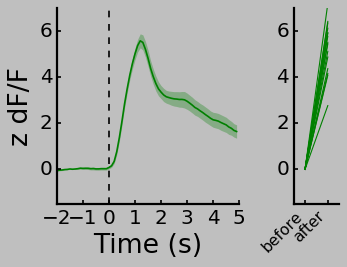

In [0]:
output_color='green'
title = 'LHA-LHb'
from matplotlib import gridspec

fig = plt.figure(figsize=(4.5, 3.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1]) 
ax1 = fig.add_subplot(gs[0])
ax1.patch.set_visible(False) # hide the 'canvas' 

ax1.axvline(0,linestyle='--',color='black',linewidth=1.5)
ax1.plot(np.arange(-sec,sec,1/Hz),Mean_LHb_start,color=output_color,linewidth=1.5)
ax1.fill_between(np.arange(-sec,sec,1/Hz), Mean_LHb_start-Error_LHb_start,Mean_LHb_start+Error_LHb_start,
                 alpha=0.3,edgecolor=output_color,facecolor=output_color,linewidth=0)

ax1.set_xlim([-2,sec])
ax1.set_ylim(-1.5, 7)
ax1.yaxis.set_ticks([0,2,4,6])

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_color('green')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)

ax1.set_ylabel('z dF/F',fontsize=24,multialignment='center')
ax1.set_xlabel('Time (s)', fontsize=24, multialignment='center')

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='y', **tkw)
ax1.tick_params(axis='x', **tkw)

ax2 = fig.add_subplot(gs[1])
ax2.patch.set_visible(False) 
ax2.plot([1,3],LHb_stats.iloc[:,1:].T,color=output_color,linewidth=1)

ax2.set_ylim(-1.5, 7)
ax2.set_xlim([0,4])
ax2.xaxis.set_ticks([1,3])
ax2.yaxis.set_ticks([0,2,4,6])
ax2.set_xticklabels(['before','after'], rotation=45,ha='right')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)

tkw = dict(size=4, width=1.5)
ax2.tick_params(axis='y', **tkw)
ax2.tick_params(axis='x', **tkw)
ax2.xaxis.set_tick_params(labelsize=14)
ax2.yaxis.set_tick_params(labelsize=18)

plt.tight_layout()
plt.show()

In [0]:
fig.savefig(folder+'/plots/LHA-LHb_AP_mean.pdf')

# Summary of GFP recordings

In [0]:
# Choose the window for Arrays
Hz = 5
sec = 5
win = int(sec*Hz)

# Pr-set arrays
Mice = []
Paths = []
Tests = []
Arrays = []

LHA_files = find_file(folder,'GFP')
# Analyse all files
for name in LHA_files:   

# Extract experiment info, tables with green and red signal, and anymaze data
  exp_info,df_fp = get_data(name,folder)
  df_fp = df_fp[2:]

# Extract behavior data. Airpuffs
  rawevents = get_behavior(df_fp)
  
# Experiment time based on frequency 
  rawtime = np.arange(0,len(df_fp)/(1*Hz),1/Hz)
  
# Remove beginning of the signals, where alignment is difficult
  remove = 20*Hz
  time = rawtime[remove:]
  events = rawevents - remove
  events = events[np.all(events > 0, axis=1)]
    
# Get number of fibers
  fiber = exp_info['fiber']
        
  print(exp_info['mouse'])

# Get signals
  raw415 = df_fp['MeanInt_410nm_'+str(fiber*2+1)]
  try:
      raw470 = df_fp['MeanInt_470nm_'+str(fiber*2+1)]
  except:
      raw470 = df_fp['MeanInt_470560nm_'+str(fiber*2+1)]
        
# Get z dF/F
  zdFF = get_zdFF(raw415,raw470,time,5e5,remove,events,exp_info,
           color='green',fiber=fiber,test='airpuff',plot=True,save=True)
# Get Arrays of signal aligned to airpuffs
  Array_events,_ = norm_events(zdFF,events=events)

# Create vectors for table
  mouse = [exp_info['mouse']] * Array_events.shape[1]
  path = [exp_info['green'][fiber]] * Array_events.shape[1]
  test = [exp_info['test']] * Array_events.shape[1]
  Mice.extend(mouse)
  Paths.extend(path)
  Tests.extend(test)
  Arrays.extend(Array_events.T)

Info = pd.DataFrame({'mouse': Mice, 'path': Paths, 'test': Tests})
Arrays = np.array(Arrays).reshape(len(Mice),win*2).astype('float64')
Arrays = pd.DataFrame(Arrays)
Arrays.columns = [str((i-win)/Hz) for i in range(2*win)]

# Combine the vectors
Arrays = pd.concat([Info, Arrays], axis=1)

GFP2
GFP1


In [0]:
LHb_start = Arrays.iloc[:,3:].T
Mean_LHb_start = LHb_start.mean(axis=1)
Error_LHb_start = LHb_start.std(axis=1) / np.sqrt(LHb_start.shape[1])

In [0]:
LHb_baseline = list(LHb_start.iloc[15:20,:].mean())
LHb_airpuff = list(LHb_start.iloc[29:33,:].mean())
LHb_mice = list(LHb_start.columns.values)
LHb_stats = pd.DataFrame({'mouse': LHb_mice, 'baseline': LHb_baseline, 'airpuff': LHb_airpuff})

In [0]:
LHb_start.iloc[29:33,:]

,0,1,2,3,4,5,6,7,8,9
0.8,0.814495,-0.049980,-0.294541,0.122328,-0.111436,-0.082030,-0.190598,-0.031751,-0.127860,-0.197867
1.0,0.905375,-0.193576,-0.169927,-0.183665,0.036120,-0.132947,-0.244697,0.056850,-0.094336,-0.186219
1.2,0.562691,-0.261222,0.209819,-0.335555,0.191771,-0.201530,-0.323624,0.085237,-0.175118,-0.337677
1.4,0.491847,-0.489059,-0.186281,-0.337283,0.148475,-0.246891,-0.458860,0.021626,-0.182260,-0.378875


In [0]:
LHb_stats.to_csv(folder+'/GFP_forJove_stats.csv')

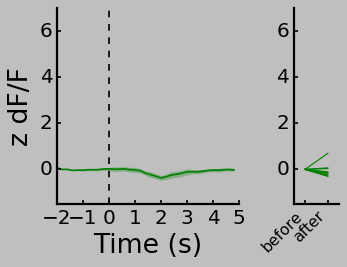

In [0]:
output_color='green'
title = 'LHA-LHb'
from matplotlib import gridspec

fig = plt.figure(figsize=(4.5, 3.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1]) 
ax1 = fig.add_subplot(gs[0])
ax1.patch.set_visible(False) # hide the 'canvas' 

ax1.axvline(0,linestyle='--',color='black',linewidth=1.5)
ax1.plot(np.arange(-sec,sec,1/Hz),Mean_LHb_start,color=output_color,linewidth=1.5)
ax1.fill_between(np.arange(-sec,sec,1/Hz), Mean_LHb_start-Error_LHb_start,Mean_LHb_start+Error_LHb_start,
                 alpha=0.3,edgecolor=output_color,facecolor=output_color,linewidth=0)

ax1.set_xlim([-2,sec])
ax1.set_ylim(-1.5, 7)

ax1.yaxis.set_ticks([0,2,4,6])

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_color('green')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)

ax1.set_ylabel('z dF/F',fontsize=24,multialignment='center')
ax1.set_xlabel('Time (s)', fontsize=24, multialignment='center')

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='y', **tkw)
ax1.tick_params(axis='x', **tkw)

ax2 = fig.add_subplot(gs[1])
ax2.patch.set_visible(False) 
ax2.plot([1,3],LHb_stats.iloc[:,1:].T,color=output_color,linewidth=1)

ax2.set_ylim(-1.5, 7)
ax2.set_xlim([0,4])
ax2.xaxis.set_ticks([1,3])
ax2.yaxis.set_ticks([0,2,4,6])
ax2.set_xticklabels(['before','after'], rotation=45,ha='right')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)

tkw = dict(size=4, width=1.5)
ax2.tick_params(axis='y', **tkw)
ax2.tick_params(axis='x', **tkw)
ax2.xaxis.set_tick_params(labelsize=14)
ax2.yaxis.set_tick_params(labelsize=18)

plt.tight_layout()
plt.show()

In [0]:
fig.savefig(folder+'/GFP_AP_mean.pdf')

In [0]:
LHb_start.iloc[28:32,:]

mouse,GFP1,GFP2
0.6,-0.260962,0.198735
0.8,-0.327478,0.114538
1.0,-0.301456,0.089691
1.2,-0.448412,0.079775
